In [1]:
import glob
import numpy as np
import oceanDAS as odas
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import netCDF4 as nc
import xarray as xr
from datetime import date, datetime, timezone
from scipy import signal, integrate
from os import path

%matplotlib inline
%cd -q '/Users/hglover/Library/CloudStorage/Box-Box/FiberExperiments/DAScomparison_paper/'


In [2]:
pname = 'OliktokPoint_Smith/7960/'
fname = 'CODAS.D7__20220816_220003.702__chn--7960.ncdf'
SWIFT = xr.open_dataset (pname+fname)
print(SWIFT)

<xarray.Dataset>
Dimensions:  (x: 7200)
Dimensions without coordinates: x
Data variables:
    data     (x) float32 ...
Attributes:
    channel:    7960.0
    dist_km:    16.129541397094727
    bearing:    362.9857482910156
    latitude:   70.6199722290039
    longitude:  -150.00001525878906
    bathy_m:    -12.5767822265625
    UTC_Time:   16-Aug-2022 22:00:03.702
    dt_s:       0.5
    npts:       7200.0
    units:      nm/m/s


In [3]:
# # make single file from all records at 7960 channel
# pname = 'OliktokPoint_Smith/7960'


# #get all times from file names
# fnames = glob.glob(pname+'/*.ncdf')
# file_time = sorted([path.basename(x) for x in fnames])
# fs = 2
# file_time = np.asarray([datetime.strptime(x[10:28],'%Y%m%d_%H%M%S.%f').timestamp() for x in file_time])
# file_time -= (7*60*60)
# # load all data for this channel from 15 second file segments
# strain_rate = []
# das_time = []
# for ti in range(len(file_time)):
#     d = nc.Dataset(fnames[ti]) 
#     strain_rate = np.append(strain_rate,d['data'][:]) 
#     t = file_time[ti] + np.arange(0,len(d['data'][:])*(1/fs),1/fs)
#     das_time = np.append(das_time,t) #check actual name of time field in netcdf
# strain_rate *= 1e-9 # data was saved in nano-strainrate (nm/m/s) -> convert back to strain rate (m/m/s)
# #convert to strain from strain rate



# np.savez('compiled7960strain', e = strain_rate, t = das_time, fs = fs)

In [4]:
# # plot example
# pname = 'OliktokPoint_Smith/'
# chn = sorted([int(path.basename(x)) for x in glob.glob(pname+'rawdata/*')])
# chn_want = chn[150:]
# print(chn_want)

# t1 = datetime(2021, 11, 10, 15, 0, 0).timestamp()
# t2 = datetime(2021, 11, 11, 16, 0, 0).timestamp()

# rawstrain,das_time,chnl,depth,X,metadata = odas.loadOliktok(pname,chn_want,t1,t2)
# rawstrain = rawstrain[:(100*60*5),:]
# das_time = das_time[:(100*60*5)]
# tvec = mdates.date2num((das_time)*1e+6)
# day = datetime.utcfromtimestamp(das_time[0]).strftime('%d-%b-%Y')
# ns,nx = rawstrain.shape

# fig, ax = plt.subplots(3,1,figsize=(10,10))
# ax[0].plot(X,depth)
# ax[0].set_ylim([-15,-8])
# ax[0].set_ylabel('Water depth (m)')
# ax[1].pcolormesh(X, tvec, rawstrain,cmap='RdBu',vmin=-1e-9,vmax=1e-9) 
# ax[1].set_ylabel('Time on '+day)
# ax[1].yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# ax[1].set_xlabel('Distance along cable (km)')

# fk_filter_matrix = odas.fk_filter_design((ns,nx), dx=metadata['dx'], fs=metadata['fs'], 
#                                          cs_min=5, cp_min=6, cp_max=11, cs_max=12)
# filtstrain = odas.fk_filter_filt(rawstrain, fk_filter_matrix)

# pcm = ax[2].pcolormesh(X, tvec, filtstrain,cmap='RdBu',vmin=-1e-10,vmax=1e-10) #
# ax[2].yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# ax[2].set_ylabel('Time on '+day)
# plt.colorbar(pcm,ax=ax[2],location='bottom',fraction=0.046, pad=0.04)


/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


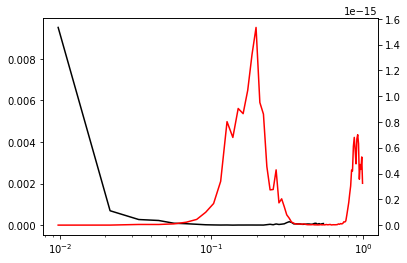

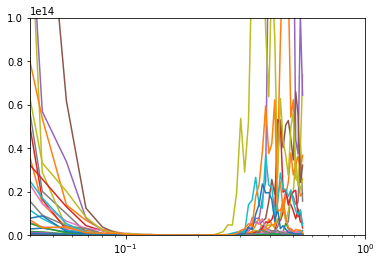

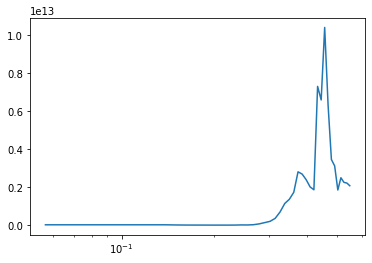

In [5]:
pname = 'OliktokPoint_Smith/'
with np.load(pname+'compiled7960strain.npz') as f:
    rawstrain = f['e']
    das_time = f['t']
depth = 12.5 # from metadata
fs = 2
tvec = mdates.date2num((das_time)*1e+6)
ns = len(rawstrain)


# load relevant data from swift
d = nc.Dataset(pname+'SWIFT18_OliktokPt_Aug2022_reprocessedIMU_1Hzspectra_convertedTe.nc')
tvec_swft = d['time'][:] + datetime.strptime('2022-08-13T22:00:00','%Y-%m-%dT%H:%M:%S').timestamp()
f_swft = d['freq'][:]
E_swft = d['energy'][:] # energy(time, freq)
Hs_swft = d['energywaveperiod'][:]
Te_swft = d['sigwaveheight_new'][:]
Tp_swft = d['peakwaveperiod'][:]

# calculate depth attenuation function for this channel location
L,_ = odas.dispersion(abs(depth),1/f_swft)
attenuation = np.exp((1/L)*depth)**2 # square for energy
attenuation[attenuation>150] = np.nan; # cut it off when correction too big,don't amplify noise
E_swft = E_swft/attenuation


# example calculation for a single hour:
# calculate a frequency dependent strain factor by comparing spectra of strain and pressure
numvals = 60*30*fs
nperseg = 512*30
t1 = datetime(2022, 8, 20, 0, 0, 0).timestamp()
t2 = datetime(2022, 8, 21, 0, 0, 0).timestamp()
idx = np.arange(t1,t2,60*60)


frqS, psd_strain = signal.welch(rawstrain[(das_time>=t1) & (das_time<(t1+numvals))], fs=fs, window='hann', nperseg=5*60*fs,detrend=False)
psd_strain = np.interp(f_swft,frqS,psd_strain)
psd_press = E_swft[(tvec_swft>=t1) & (tvec_swft<(t1+numvals)),:]
strain_fac = psd_press/psd_strain

fig,ax = plt.subplots(1,1)
ax.plot(f_swft,psd_press.T,'k')
ax2 = ax.twinx()
ax2.plot(f_swft,psd_strain,'r')
ax.set_xscale('log')


plt.figure()
for jj in range(1,len(idx)-1):
    frqS , psd_strain = signal.welch(rawstrain[(das_time>=idx[jj]) & (das_time<(idx[jj]+numvals))], fs=fs, window='hann', nperseg=5*60*fs,detrend=False)
    psd_strain = np.interp(f_swft,frqS,psd_strain)
    psd_press = E_swft[(tvec_swft>=idx[jj]) & (tvec_swft<(idx[jj]+numvals)),:]
    temp = psd_press/psd_strain
    strain_fac = np.vstack([strain_fac,temp])
    plt.plot(f_swft,temp.T)
plt.xscale('log')    
plt.xlim([0.04,1])
plt.ylim([0,1e14])
strain_fac_mean = np.median(strain_fac,axis=0)

strain_fac_mean[f_swft<0.15] = min(strain_fac_mean[f_swft<0.15])
strain_fac_mean[(f_swft<0.05) | (f_swft>0.55)] = np.nan


plt.figure()
plt.plot(f_swft,strain_fac_mean)
plt.xscale('log')
# plt.xlim([0.04,1])
# plt.ylim([0,1e14])
np.savez('straincorrfac7960', c = strain_fac_mean, f = f_swft)